# Self-attention:

In this notebook, we will explore Self-attention, which includes incorporating a trainable self-attention module into a ResNet architecture. We apply this module to the last convolutional block. For more information, you can refer to the original attention paper (Attention is All You Need) through [this link](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

In [1]:
# installing required packages
%pip install gradio
%pip install opencv-python
%pip install imgaug


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: /fs01/projects/aieng/public/interp_bootcamp/venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: /fs01/projects/aieng/public/interp_bootcamp/venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: /fs01/projects/aieng/public/interp_bootcamp/venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
from glob import glob
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from imgaug import augmenters as iaa
import cv2
from tqdm import tqdm
from torch.utils.data.sampler import Sampler
from torch.nn import functional as F
from torch.nn.modules import Module
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, precision_score
from torchvision import transforms
import sys
import argparse
import logging
import random
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Subset,SubsetRandomSampler, TensorDataset
from functools import partial
import torchvision.models as models
from tqdm import tqdm
from torch.autograd import Variable
plt.rcParams['figure.figsize'] = [25, 10]
import gradio as gr
from glob import glob
from PIL import Image
import gc
from pathlib import Path

In [16]:
def load_checkpoint(model, optimizer,file_path):
    checkpoint = torch.load(file_path, map_location="cuda:0")

    checkpoint_state_dict = checkpoint['model_state_dict']


    # Create a new state_dict with only the matching keys
    checkpoint_state_dict = {k.replace('module.', ''): v for k, v in checkpoint_state_dict.items()}

    filtered_state_dict = {k: v for k, v in checkpoint_state_dict.items() if k in model.state_dict()}# and "mlp.mlp_layers.dense_1" not in k and "mlp.mlp_layers.dense_0" not in k and "num_norm" not in k}

    model.load_state_dict(filtered_state_dict, strict=False)

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model

In [10]:
# Initializing model hyperparameters
# batch_size = 32
# epochs = 20
lr = 1e-3
# dropout = 0.5
weight_decay = 1e-3
# num_epochs = 20


## Data:

In this project, we use the "NIH" dataset, which is publicly accessible at [here](https://www.kaggle.com/datasets/nih-chest-xrays/data). It contains 112120 chest X-rays corresponding to 14 different conditions, e.g., Pneumonia. The goal is to train a predictive model to classify each image to one or multiple conditions, considering the problem as 15 binary classification tasks (including Normal).

In [4]:
def read_image(image_path):
    image = cv2.imread(image_path)
    image = image/np.max(image)
    return image

class XrayDataset(Dataset):
    def __init__(self, csv_file, image_path_name):

        self.path_name = image_path_name
        self.csv_file = csv_file
        self.the_chosen, self.all_classes, self.all_classes_dict = self.choose_the_indices()
        self.csv_file["numeric_targets"] = self.csv_file['Finding Labels'].apply(lambda x: self.get_tagets(x))
    def __len__(self):

        return len(self.csv_file)
    def choose_the_indices(self):

        max_examples_per_class = 10000 # its the maximum number of examples that would be sampled in the training set for any class
        the_chosen = []
        all_classes = {}
        length = len(self.csv_file)
        print('\nSampling the huuuge training dataset')
        for i in tqdm(list(np.random.choice(range(length),length, replace = False))):

            temp = str.split(self.csv_file.iloc[i, :]['Finding Labels'], '|')

            # special case of ultra minority hernia. we will use all the images with 'Hernia' tagged in them.
            if 'Hernia' in temp:
                the_chosen.append(i)
                for t in temp:
                    if t not in all_classes:
                        all_classes[t] = 1
                    else:
                        all_classes[t] += 1
                continue

            # choose if multiple labels
            if len(temp) > 1:
                bool_lis = [False]*len(temp)
                # check if any label crosses the upper limit
                for idx, t in enumerate(temp):
                    if t in all_classes:
                        if all_classes[t]< max_examples_per_class: # 500
                            bool_lis[idx] = True
                    else:
                        bool_lis[idx] = True
                # if all lables under upper limit, append
                if sum(bool_lis) == len(temp):
                    the_chosen.append(i)
                    # maintain count
                    for t in temp:
                        if t not in all_classes:
                            all_classes[t] = 1
                        else:
                            all_classes[t] += 1
            else:        # these are single label images
                for t in temp:
                    if t not in all_classes:
                        all_classes[t] = 1
                    else:
                        if all_classes[t] < max_examples_per_class: # 500
                            all_classes[t] += 1
                            the_chosen.append(i)



        '''
        if len(the_chosen) != len(set(the_chosen)):
            print('\nGadbad !!!')
            print('and the difference is: ', len(the_chosen) - len(set(the_chosen)))
        else:
            print('\nGood')
        '''
        with open('all_classes.pkl', 'wb') as file:
            pickle.dump(all_classes, file)
        return the_chosen, sorted(list(all_classes)), all_classes

    def get_tagets(self,row):
        labels = str.split(row, '|')

        target = torch.zeros(len(self.all_classes))
        for lab in labels:
            lab_idx = self.all_classes.index(lab)
            target[lab_idx] = 1
        return target
    def get_image(self, idx):
        # -- Query the index location of the required file

        image_name = self.csv_file.loc[idx,'Image Index']

        image_path = glob(os.path.join(self.path_name, '**', image_name), recursive=True)[0]
        image = read_image(image_path)
        if len(image.shape) == 2: image = np.expand_dims(image, axis=-1)

        labels = str.split(self.csv_file.loc[idx,'Finding Labels'], '|')

        target = torch.zeros(len(self.all_classes))
        for lab in labels:
            lab_idx = self.all_classes.index(lab)
            target[lab_idx] = 1
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        input_size = 224
        rseed = 42
        seq = iaa.Sequential([iaa.Resize((input_size, input_size))])
        image_transform = transforms.Compose([seq.augment_image, transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        image = image_transform(image)
        return image.float(), target


    def num_sort(self, filename):
        not_num = re.compile("\D")
        return int(not_num.sub("", filename))

    def __getitem__(self, idx):
        image, label = self.get_image(idx)
        return image,label


In [5]:
image_path = "/datasets/nih-chest-xrays"
test_split = os.path.join(image_path,"test_list.txt")
df = pd.read_csv(os.path.join(image_path,"Data_Entry_2017.csv"))
with open(test_split, 'r') as f:
    test_images = f.read().splitlines()
test_df = df[df['Image Index'].isin(test_images)]

In [6]:
dataset = XrayDataset(df, image_path) # Initializing the dataset


Sampling the huuuge training dataset


100%|██████████| 112120/112120 [00:11<00:00, 9801.84it/s] 


In [33]:
# Here, we extract one image from the dataset along with its label.
idx = 78  # selecting a single index 
image, label = dataset[idx]
image, label = image.cuda() , label.cuda() # transferring the extracted datapoint to the GPU
image = image.unsqueeze(0)  # Shape: [1, C, H, W] # adding batch dimension (since models expect a batch input)

### Model:

We have fine-tuned a ResNet-18 model pretrained ImageNet on the NIH dataset. To find the code used for this task, you can refer to the train_attention function.

This model contains a self-attention module applied to the last convolutional block.This modul consists of three main elements: query, key, and value, similar to the original attention mechanism. The attention weights are extracted from this module for heatmap visualization.

In [8]:
# model architechture
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        # calculating attention weights
        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        value = self.value(x).view(batch_size, -1, width * height)
        # calculating weighted context
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x # weighted context added to the original input in a residual manner
        return out, attention

class ResNetAttention(nn.Module):
    def __init__(self, original_model,num_classes=15):
        super(ResNetAttention, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.attention = SelfAttention(in_dim=512)  # Adjust channels based on ResNet block
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)  # Output channels should match in_channels of attention layer
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x, attention = self.attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x,attention # returns the logits along with the attention weights

In [14]:
# Creating a model instance
model = ResNetAttention(models.resnet18(pretrained=True))
model = model.cuda() # transferring the model to the GPU
optimizer = optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)

Here, we load the fine-tuned model checkpoints and use it to generate self-attention heatmaps.

In [34]:
# weight_path = "/ssd003/projects/aieng/public/interp_bootcamp/checkpoints/resnet.pth"
weight_path = "/scratch/ssd004/scratch/sketabi/model_intepretability/imaging_copy/output_weight/new_resnet_attention.pth"
model = load_checkpoint(model, optimizer,weight_path)
model.eval() 
# Make predictions
with torch.no_grad():
    logits , attention_weights = model(image)

# Convert output to probabilities (assuming binary/multi-label classification)
class_probs = torch.sigmoid(logits)  # For multi-label classification

In [18]:
classes = dataset.all_classes
print(classes)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## Generating Attention Heatmaps

Now, we interpolate the extracted attention weights to the input image size, and visualize them through a heatmap. The heatmap is then projected onto the image.

In [19]:
def visualize_trainable_attention(attention_weights, image,label):

    fig, ax = plt.subplots()
    
    attn_map_upscaled = F.interpolate(
        attention_weights.mean(1).view(7,7).unsqueeze(0).unsqueeze(0).clamp(0, 1),  # Add channel dims
        size=(224, 224),
        mode='bilinear',
        align_corners=False)
    print(attn_map_upscaled.shape)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    

    ax.imshow(image.squeeze(0).permute(1, 2, 0).cpu().clamp(0, 1))  # Original image
    ax.imshow(attn_map_upscaled.squeeze(0).permute(1, 2, 0).cpu(), cmap='jet', alpha=0.5) 

torch.Size([1, 1, 224, 224])


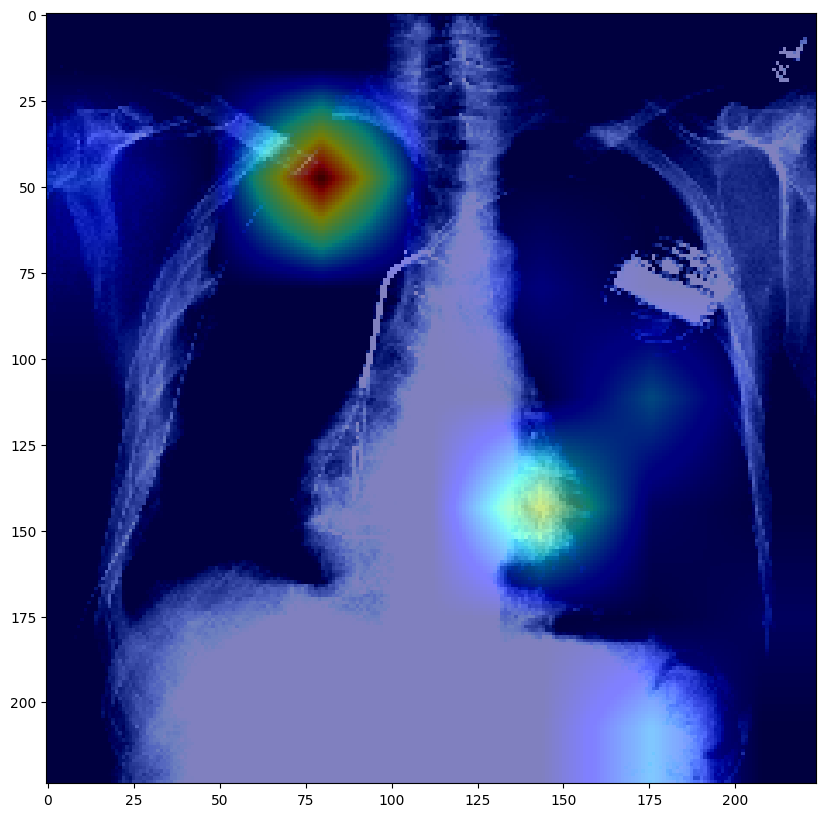

In [35]:
visualize_trainable_attention(attention_weights, image,label)

The generated explanation can highlight potential parts of the input image atteded by the model for making the prediction.